# Определение района квартиры в Магнитогорске

**id для демонстрации на собеседовании**
id = 3, 37, 82

## Введение

**Задача**

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.


Модель должна иметь REST API. На вход модели подаются параметры квартиры в формате JSON на выходе получается цена квартиры в формате JSON.

Испытание проводится в режиме демонстрации экрана на собеседовании. Модель тестируется на 3х квартирах на выбор кандидата. (Просьба подготовить исходные данные (запросы) заранее)


**Данные**


В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru.

Размер выборки исходных данных не имеет значения, однако она должна быть представительной (не следует делать ее слишком большой, т.к. задача тестовая).

Данные должны быть загружены в базу данных.

## Импорт библиотек и загрузка данных

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

RANDOM_STATE = 12345

In [2]:
# подключаемся к базе данных
cnx = sqlite3.connect('db/magnitogorsk.db')

In [3]:
# загружаем данные
data = pd.read_sql_query("SELECT * FROM offers", cnx)

In [4]:
# закрываем соединение с базой данных
cnx.close()

## Первичное знакомство с данными

In [5]:
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [6]:
first_look(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              456 non-null    int64  
 1   type            445 non-null    object 
 2   district        254 non-null    object 
 3   adress          456 non-null    object 
 4   floor           456 non-null    object 
 5   total_square    456 non-null    float64
 6   living_square   456 non-null    float64
 7   kitchen_square  456 non-null    float64
 8   price           456 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 32.2+ KB


None

Первые 5 строк(и) данных


,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800


Основные статистические характеристики данных


,id,total_square,living_square,kitchen_square,price
count,456.00000,456.000000,456.000000,456.000000,456.000000
mean,228.50000,53.514912,32.120175,8.771250,3744.561404
std,131.78012,21.751910,17.343334,4.007841,1631.107124
min,1.00000,14.100000,0.000000,0.000000,0.000000
25%,114.75000,40.175000,19.000000,6.000000,2700.000000
50%,228.50000,50.000000,30.000000,8.050000,3500.000000
75%,342.25000,65.000000,43.000000,10.000000,4600.000000
max,456.00000,220.000000,150.000000,30.000000,10000.000000


Количество пропусков:
id                  0
type               11
district          202
adress              0
floor               0
total_square        0
living_square       0
kitchen_square      0
price               0
dtype: int64

Количество дубликатов: 0


Посмотрим, есть ли в данных дубликаты, если мы не будем учитывать столбец id.

In [7]:
print('Количество дубликатов:', data.drop('id', axis=1).duplicated().sum())

Количество дубликатов: 2


In [8]:
data[data.drop('id', axis=1).duplicated()]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
354,355,Двухкомнатная раздельная,Орджоникидзевский (левый берег),Трамвайная 25,1/3,43.0,31.0,6.0,2350
413,414,Двухкомнатная,Правобережный,"Им. газеты ""Правда"" 23",4/5,46.1,29.0,6.0,2600


In [9]:
data.shape

(456, 9)

In [10]:
data.drop_duplicates(
    subset=['type', 'district', 'adress', 'floor', 'total_square', 'living_square', 'kitchen_square', 'price'],
    inplace=True
)

In [11]:
data.shape

(454, 9)

### Цена

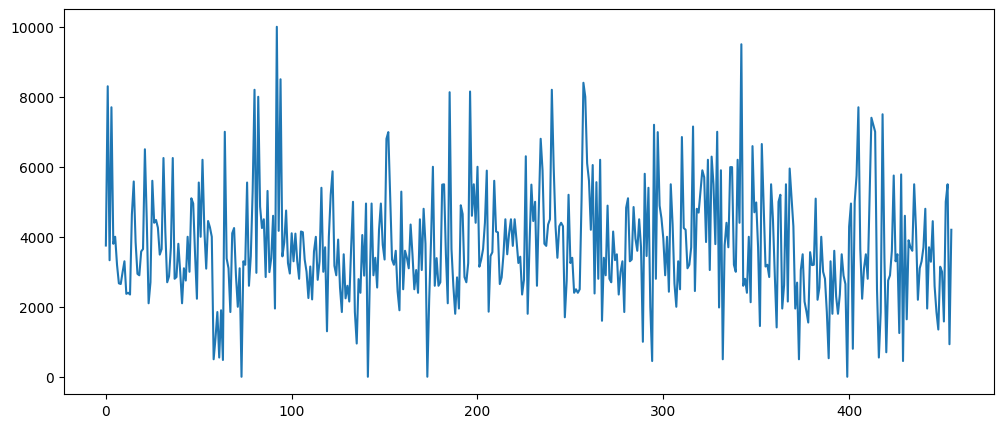

In [12]:
data['price'].plot(figsize=(12, 5));

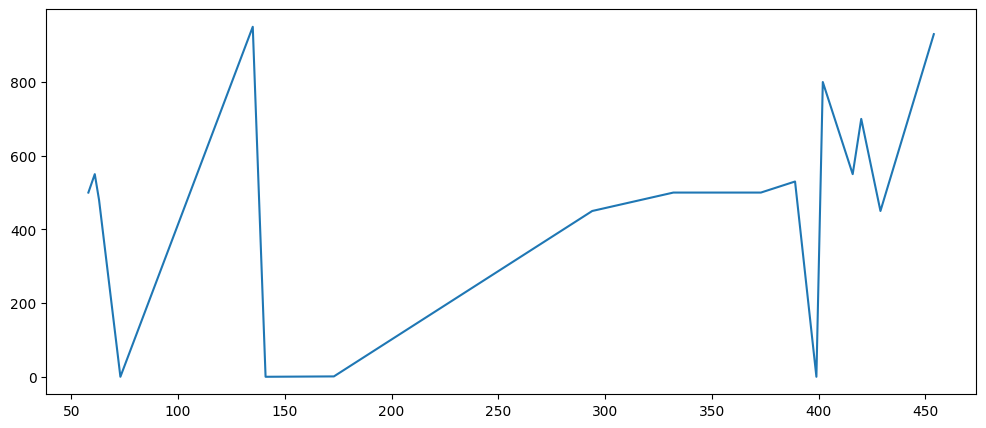

In [13]:
data[data['price'] < 1000]['price'].plot(figsize=(12, 5));

In [14]:
data[data['price'] < 800].shape[0] / data.shape[0] * 100

3.0837004405286343

In [15]:
data[data['price'] < 600]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
58,59,Трехкомнатная,None,Школьная 10,1/1,59.5,47.0,12.0,500
61,62,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,550
63,64,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,480
73,74,Однокомнатная,None,Первомайская 16,2/4,42.6,20.0,15.0,0
141,142,Однокомнатная,None,Труда 47,4/9,32.0,19.0,6.0,0
173,174,Однокомнатная малосемейка,Правобережный,Советской Армии 37/1,4/9,22.0,12.0,6.0,1
294,295,Однокомнатная,None,Привокзальная 29кв1,1/1,42.5,22.0,12.0,450
332,333,Двухкомнатная,None,Российская 7,2/2,45.0,31.0,6.0,500
373,374,Двухкомнатная,None,ул Черемушки 13,2/2,40.0,22.0,6.0,500
389,390,Трехкомнатная,None,Труда 2,1/2,63.4,0.0,0.0,530


Для трех квартир цена не указана, поэтому удалим эти строки, так как они не подходят ни для обучения модели ни для контроля качества. 

Количество квартир с нетипично низкой ценой составляет около 3 % данных. Удалим их, чтобы модель смогла точнее выявить закономерность.

In [16]:
# контроль размерности
data.shape

(454, 9)

In [17]:
data = data[data['price'] >= 800]

In [18]:
# контроль размерности
data.shape

(440, 9)

### Отбор столбцов

In [19]:
data = data.drop(['id', 'adress'], axis=1)

In [20]:
data.head()

,type,district,floor,total_square,living_square,kitchen_square,price
0,Трехкомнатная улучшенная,Орджоникидзевский,1/5,64.0,43.0,8.0,3750
1,Трехкомнатная,Ленинский,2/5,87.2,60.0,9.0,8300
2,Однокомнатная нестандартная,Орджоникидзевский,6/14,36.1,20.0,9.0,3330
3,Трехкомнатная нестандартная,Орджоникидзевский,5/16,105.0,75.0,14.0,7700
4,Двухкомнатная улучшенная,Орджоникидзевский,7/9,50.6,43.0,9.0,3800


## Построение модели

### Предварительна обработка данных

Разделим характеристики и целевую переменную.

In [21]:
data.shape

(440, 7)

In [22]:
data = data[data['district'].notna()]

In [23]:
data = data[data['type'].notna()]

In [24]:
data.shape

(249, 7)

In [25]:
data.isna().sum()

type              0
district          0
floor             0
total_square      0
living_square     0
kitchen_square    0
price             0
dtype: int64

### Трансформер для предварительной обработки данных

Напишем два трансформера для предварительной обработки данных

**Чистка данных**
- 'adress': у названий улиц уберем номера домов
- 'adress': в названиях улиц исправим неявные дубликаты
- 'district': исправим неявные дубликаты

**Преобразование характеристик**
    
- 'floor': добавляем столбец с номером этажа
- 'floor': добавляем столбец с общим количеством этажей в доме.
- 'type': добавляем столбец с количеством комнат
- 'type': добавляем столбец с типом планировки. пропуски заполняем значением «неизвестно»
- 'floor': удалим, потому что вместо него будем использовать столбцы, сгенерированные на его основе 
- 'type': удалим, потому что вместо него будем использовать столбцы, сгенерированные на его основе 
- 'adress': удалим, потому что вместо него будем использовать столбцы, сгенерированные на его основе


In [26]:
class DataCleaner(BaseEstimator, TransformerMixin):
    '''
    Класс для обработки неявных дубликатов и пропусков
    '''
    def __init__(self):
        self.districts_to_replace = {
            'ленинский' : 'Ленинский',
            'Орджоникидзевский район' : 'Орджоникидзевский',
            'Орджо' : 'Орджоникидзевский',
            'правобережный' : 'Правобережный'
        }
           
    def fit(self, X):
        return self

    def transform(self, X):
         
        # обработка дубликатов и пропусков района
        X['district'].replace(to_replace=self.districts_to_replace, inplace=True)
        X['district'].fillna('неизвестно', inplace=True)
                        
        return X

In [27]:
class FeaturesTransformer(BaseEstimator, TransformerMixin):
    '''
    Класс для преобразования характеристик.
    
    Добавляет:
        floor_num - номер этажа
        total_floors - общее количество этажей
        num_of_rooms - количество комнат
        flat_type - тип планировки

    Удаляет: 
        floor - так как заменен на два более информативных признака
        type - так как заменен на два более информативных признака
    '''
    columns_ = [
        'district',  
        'total_square', 
        'living_square', 
        'kitchen_square', 
        'price',
        'floor_num', 
        'total_floors', 
        'num_of_rooms', 
        'flat_type'
    ]
    def __init__(self):
        pass
        
    def __get_floor_num(self, row):
        return int(row[:row.find('/')])
    
    def __get_total_floors(self, row):
        return int(row[row.find('/')+1:])

    def __get_num_of_rooms(self, row):
        return row[: row.find(' ')] if row.find(' ') > 0 else None

    def __get_flat_type(self, row):
        return 'неизвестно' if (len(row) - row.find(' ') == 1) or (row.find(' ') == -1) else row[row.find(' ')+1:]
    
    def fit(self, X):
        return self

    def transform(self, X):
         
        # номер этажа квартиры
        floor_num = X['floor'].apply(self.__get_floor_num)

        # общее количество этажей в доме
        total_floors = X['floor'].apply(self.__get_total_floors)

        num_of_rooms = X['type'].apply(self.__get_num_of_rooms)
        flat_type = X['type'].apply(self.__get_flat_type)
        
        X = pd.DataFrame(np.c_[X.drop(['floor', 'type'], axis=1), floor_num, total_floors, num_of_rooms, flat_type])    
        X.columns = self.columns_
        return X

Выделим категориальные и числовые признаки.

In [28]:
knn_pipeline =  Pipeline([
    ('data_cleaner', DataCleaner()),
    ('features_transformer', FeaturesTransformer())
])

In [29]:
data = knn_pipeline.fit_transform(data)

In [30]:
data.head()

,district,total_square,living_square,kitchen_square,price,floor_num,total_floors,num_of_rooms,flat_type
0,Орджоникидзевский,64.0,43.0,8.0,3750,1,5,Трехкомнатная,улучшенная
1,Ленинский,87.2,60.0,9.0,8300,2,5,Трехкомнатная,неизвестно
2,Орджоникидзевский,36.1,20.0,9.0,3330,6,14,Однокомнатная,нестандартная
3,Орджоникидзевский,105.0,75.0,14.0,7700,5,16,Трехкомнатная,нестандартная
4,Орджоникидзевский,50.6,43.0,9.0,3800,7,9,Двухкомнатная,улучшенная


In [31]:
data.shape

(249, 9)

In [32]:
data = data[data['num_of_rooms'] != 'Многокомнатная']

In [33]:
data.shape

(248, 9)

In [34]:
data['num_of_rooms'].unique()

array(['Трехкомнатная', 'Однокомнатная', 'Двухкомнатная',
       'Четырехкомнатная'], dtype=object)

In [35]:
num_of_rooms_replace = {
    'Однокомнатная' : 1, 
    'Двухкомнатная' : 2,
    'Трехкомнатная' : 3, 
    'Четырехкомнатная' : 4
}

In [36]:
data['num_of_rooms'].replace(num_of_rooms_replace, inplace=True)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 248
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   district        248 non-null    object
 1   total_square    248 non-null    object
 2   living_square   248 non-null    object
 3   kitchen_square  248 non-null    object
 4   price           248 non-null    object
 5   floor_num       248 non-null    object
 6   total_floors    248 non-null    object
 7   num_of_rooms    248 non-null    int64 
 8   flat_type       248 non-null    object
dtypes: int64(1), object(8)
memory usage: 19.4+ KB


In [38]:
data['total_square'] = data['total_square'].astype('float')
data['living_square'] = data['living_square'].astype('float')
data['kitchen_square'] = data['kitchen_square'].astype('float')
data['price'] = data['price'].astype('int')
data['floor_num'] = data['floor_num'].astype('int')



In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 248
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        248 non-null    object 
 1   total_square    248 non-null    float64
 2   living_square   248 non-null    float64
 3   kitchen_square  248 non-null    float64
 4   price           248 non-null    int32  
 5   floor_num       248 non-null    int32  
 6   total_floors    248 non-null    object 
 7   num_of_rooms    248 non-null    int64  
 8   flat_type       248 non-null    object 
dtypes: float64(3), int32(2), int64(1), object(3)
memory usage: 17.4+ KB


In [40]:
data['district'].unique()

array(['Орджоникидзевский', 'Ленинский', 'Правобережный',
       'Орджоникидзевский (левый берег)'], dtype=object)

In [41]:
data['district'].value_counts()

district
Орджоникидзевский                  111
Ленинский                           75
Правобережный                       51
Орджоникидзевский (левый берег)     11
Name: count, dtype: int64

In [42]:
district_to_replace = {
    'Орджоникидзевский' : 1, 
    'Орджоникидзевский (левый берег)' : 2,
    'Ленинский' : 3, 
    'Правобережный' : 4
}

In [43]:
data['district'].replace(district_to_replace, inplace=True)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 248
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        248 non-null    int64  
 1   total_square    248 non-null    float64
 2   living_square   248 non-null    float64
 3   kitchen_square  248 non-null    float64
 4   price           248 non-null    int32  
 5   floor_num       248 non-null    int32  
 6   total_floors    248 non-null    object 
 7   num_of_rooms    248 non-null    int64  
 8   flat_type       248 non-null    object 
dtypes: float64(3), int32(2), int64(2), object(2)
memory usage: 17.4+ KB


### Подготовка обучающей и валидационной выборки.

Выделим характеристики, которые будем использовать для обучения модели.

Разобьем выборки на обучающую и валидационную в отношении 4 : 1.

In [45]:
features = data.drop(['district', 'total_floors', 'flat_type'], axis=1)
target = data['district']

In [46]:
features

,total_square,living_square,kitchen_square,price,floor_num,num_of_rooms
0,64.0,43.0,8.0,3750,1,3
1,87.2,60.0,9.0,8300,2,3
2,36.1,20.0,9.0,3330,6,1
3,105.0,75.0,14.0,7700,5,3
4,50.6,43.0,9.0,3800,7,2
...,...,...,...,...,...,...
244,50.0,36.0,12.0,2590,2,2
245,26.0,14.0,7.0,3145,5,1
246,67.2,45.0,12.0,5000,1,3
247,74.0,56.0,9.0,5500,5,3


In [47]:
target

0      1
1      3
2      1
3      1
4      1
      ..
244    1
245    4
246    4
247    3
248    1
Name: district, Length: 248, dtype: int64

In [48]:
features_train, features_val, target_train, target_val = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=RANDOM_STATE
)

## KMeans

In [49]:
from sklearn.cluster import KMeans

In [50]:
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init="auto").fit(features_train)

In [51]:
predictions = kmeans.predict(features_train)
predictions

array([0, 1, 3, 3, 3, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 3, 2, 0, 2, 3, 0, 0, 1, 1, 1, 0, 3, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 3, 1, 0, 3, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 3, 3, 0, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 3, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 0, 0,
       3, 1, 1, 0, 0, 3, 1, 1, 3, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 3, 3, 0, 3, 3, 1, 0, 3, 1, 3, 3, 0, 2, 0, 1, 2, 0,
       1, 0, 1, 1, 0, 1, 0, 3, 0, 3, 1, 2, 1, 3, 1, 0, 3, 0, 3, 0, 2, 0])

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
accuracy_score(target_train, predictions)

0.2727272727272727

In [54]:
predictions_val = kmeans.predict(features_val)
accuracy_score(target_val, predictions_val)

0.18

In [55]:
features_train.columns

Index(['total_square', 'living_square', 'kitchen_square', 'price', 'floor_num',
       'num_of_rooms'],
      dtype='object')

In [56]:
for i in range(1, len(features_train.columns)):
    print(features_train.columns[:i])
    kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init="auto").fit(features_train[features_train.columns[:i]])
    predictions = kmeans.predict(features_train[features_train.columns[:i]])
    print(accuracy_score(target_train, predictions))
    print('-------------')
    print()

Index(['total_square'], dtype='object')
0.21212121212121213
-------------

Index(['total_square', 'living_square'], dtype='object')
0.0707070707070707
-------------

Index(['total_square', 'living_square', 'kitchen_square'], dtype='object')
0.06565656565656566
-------------

Index(['total_square', 'living_square', 'kitchen_square', 'price'], dtype='object')
0.2727272727272727
-------------

Index(['total_square', 'living_square', 'kitchen_square', 'price',
       'floor_num'],
      dtype='object')
0.2727272727272727
-------------



## MiniBatchKMeans

In [57]:
from sklearn.cluster import MiniBatchKMeans

In [70]:
best_model = None
best_score = 0
# best_metric = ''
for batch_size_test in [5, 10]:
    for i in range(1, len(features_train.columns)):
        print(features_train.columns[:i])
        print('batch_size_test', batch_size_test)
        model = MiniBatchKMeans(
            n_clusters=4,
            random_state=RANDOM_STATE,
            batch_size=batch_size_test,
            n_init='auto'
            ).fit(features_train[features_train.columns[:i]])
        predictions = model.predict(features_train[features_train.columns[:i]])
        # print(predictions.tolist())
        train_score = accuracy_score(target_train, predictions.tolist())
        print('train_score', train_score)
        predictions_val = model.predict(features_val[features_train.columns[:i]])
        val_score = accuracy_score(target_val, predictions_val.tolist())
        print('val_score', val_score)
        if val_score >= 0.34:
            for i in range(len(target_val)):
                print(i, '\t', target_val.iloc[i], '\t', predictions_val.tolist()[i])
        if val_score > best_score:
            best_score = val_score
            best_model = model
            best_batch = batch_size_test
        print('-------------')
        print()

print('best_score', best_score)
print('best_model', best_model)


Index(['total_square'], dtype='object')
batch_size_test 5
train_score 0.16161616161616163
val_score 0.26
-------------

Index(['total_square', 'living_square'], dtype='object')
batch_size_test 5
train_score 0.21212121212121213
val_score 0.34
0 	 4 	 3
1 	 1 	 3
2 	 3 	 3
3 	 1 	 3
4 	 3 	 3
5 	 1 	 1
6 	 3 	 0
7 	 1 	 1
8 	 1 	 3
9 	 1 	 1
10 	 4 	 3
11 	 1 	 3
12 	 3 	 3
13 	 1 	 0
14 	 4 	 1
15 	 1 	 0
16 	 4 	 0
17 	 3 	 3
18 	 1 	 3
19 	 3 	 0
20 	 1 	 3
21 	 1 	 2
22 	 3 	 3
23 	 1 	 0
24 	 1 	 0
25 	 3 	 3
26 	 1 	 1
27 	 4 	 3
28 	 4 	 3
29 	 1 	 1
30 	 1 	 1
31 	 1 	 3
32 	 1 	 3
33 	 4 	 3
34 	 3 	 3
35 	 3 	 3
36 	 1 	 0
37 	 3 	 3
38 	 3 	 3
39 	 4 	 0
40 	 1 	 0
41 	 3 	 3
42 	 1 	 3
43 	 1 	 0
44 	 4 	 3
45 	 4 	 3
46 	 3 	 1
47 	 3 	 0
48 	 3 	 1
49 	 4 	 3
-------------

Index(['total_square', 'living_square', 'kitchen_square'], dtype='object')
batch_size_test 5
train_score 0.18181818181818182
val_score 0.22
-------------

Index(['total_square', 'living_square', 'kitchen

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated 

train_score 0.13131313131313133
val_score 0.12
-------------

Index(['total_square', 'living_square', 'kitchen_square', 'price'], dtype='object')
batch_size_test 10
train_score 0.14646464646464646
val_score 0.12
-------------

Index(['total_square', 'living_square', 'kitchen_square', 'price',
       'floor_num'],
      dtype='object')
batch_size_test 10
train_score 0.14646464646464646
val_score 0.12
-------------

best_score 0.34
best_model MiniBatchKMeans(batch_size=5, n_clusters=4, n_init='auto', random_state=12345)


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1099: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(


## анализ кластеровё

In [71]:
model_1 = MiniBatchKMeans(
            n_clusters=4,
            random_state=RANDOM_STATE,
            batch_size=batch_size_test,
            n_init='auto'
            )

In [72]:
model_1.fit(features)

MiniBatchKMeans(batch_size=10, n_clusters=4, n_init='auto', random_state=12345)

In [73]:
model_1.predict(features)

array([3, 0, 3, 0, 3, 3, 3, 1, 1, 1, 3, 2, 2, 3, 0, 2, 1, 2, 3, 2, 3, 3,
       3, 2, 3, 1, 1, 3, 1, 1, 2, 2, 3, 1, 2, 3, 2, 1, 2, 3, 3, 3, 3, 2,
       3, 2, 0, 1, 0, 3, 1, 3, 2, 1, 0, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 3, 3, 0,
       2, 3, 1, 2, 1, 2, 3, 1, 2, 2, 3, 1, 0, 3, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 2, 2, 3, 1, 1, 3, 2, 3, 3, 3, 2, 3, 3, 3, 1, 1, 3, 2, 2, 2,
       1, 2, 2, 3, 3, 3, 0, 2, 3, 1, 2, 1, 2, 0, 0, 2, 2, 3, 2, 2, 1, 1,
       1, 2, 1, 3, 2, 2, 3, 3, 1, 2, 3, 1, 0, 2, 2, 2, 3, 3, 1, 0, 3, 3,
       1, 3, 1, 2, 2, 3, 2, 1, 2, 3, 3, 3, 2, 2, 3, 1, 2, 1, 1, 3, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1,
       3, 2, 2, 0, 3, 1, 1, 1, 1, 0, 3, 1, 3, 2, 3, 3, 1, 1, 3, 1, 3, 3,
       2, 1, 3, 2, 2, 3])

In [74]:
new_data = features

In [75]:
new_data['predictions'] = model_1.predict(features)

In [77]:
new_data['district'] = target

In [78]:
new_data.head()

,total_square,living_square,kitchen_square,price,floor_num,num_of_rooms,predictions,district
0,64.0,43.0,8.0,3750,1,3,3,1
1,87.2,60.0,9.0,8300,2,3,0,3
2,36.1,20.0,9.0,3330,6,1,3,1
3,105.0,75.0,14.0,7700,5,3,0,1
4,50.6,43.0,9.0,3800,7,2,3,1


In [82]:
new_data[new_data['district'] == 1]['predictions'].value_counts()

predictions
3    44
2    34
1    24
0     9
Name: count, dtype: int64

In [83]:
new_data[new_data['district'] == 2]['predictions'].value_counts()

predictions
1    9
3    2
Name: count, dtype: int64

In [84]:
new_data[new_data['district'] == 3]['predictions'].value_counts()

predictions
1    26
2    24
3    21
0     4
Name: count, dtype: int64

In [85]:
new_data[new_data['district'] == 4]['predictions'].value_counts()

predictions
3    24
1    17
2     7
0     3
Name: count, dtype: int64